In this notebook, we build a tiny Transformer language model from scratch. Instead of a standard feed-forward network (FFN), we integrate a Mixture-of-Experts (MoE) layer, consisting of multiple specialist experts and a shared expert. This allows us to visualize how different experts “specialize” in different types of text patterns during training. We train the model on the AG News dataset.

## Part 1 — Environment Setup and Imports

We begin by installing the HuggingFace datasets library, transformers for the GPT-2 tokenizer, and importing PyTorch.

This section also configures the compute device (CPU or GPU) and prepares the environment for the rest of the notebook.


In [ ]:
!pip install -q datasets transformers

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from datasets import load_dataset
from transformers import GPT2TokenizerFast

from collections import Counter
import math
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


## Part 2 — Loading AG News and Using Tokenizer

The AG News dataset contains short news articles across four topics: World, Sports, Business, and Sci/Tech.

In this section, we load AG News and prepare it for training by applying the GPT-2 Byte-Pair Encoding (BPE) tokenizer. Each news article is converted into a sequence of subword IDs, which the model will learn to embed and predict autoregressively.

In [ ]:
# Load AG News
dataset = load_dataset("ag_news")
print(dataset)

tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
pad_id = tokenizer.pad_token_id

vocab_size = tokenizer.vocab_size   # 50,257
print("GPT-2 Vocab Size:", vocab_size)

def encode(text, max_len=None):
    return tokenizer.encode(
        text,
        max_length=max_len,
        truncation=(max_len is not None),
        padding=("max_length" if max_len is not None else False)
    )

def decode(ids):
    cleaned = [i for i in ids if i != pad_id]
    return tokenizer.decode(cleaned)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

GPT-2 Vocab Size: 50257


## Part 3 — Creating a Language Modeling Dataset

Transformers trained for text generation learn to predict the **next token** at every position in the sequence.

Here we convert each AG News text into a fixed-length sequence, then create (input, target) pairs by shifting the text by one token.

This converts the raw news text into a format suitable for **autoregressive language modeling.**


In [ ]:
BLOCK_SIZE = 32  # context length (in tokens)

class AGNewsLMDataset(Dataset):
    def __init__(self, hf_dataset, block_size):
        self.data = hf_dataset
        self.block_size = block_size + 1  # +1 so we can create (input, target) pairs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]["text"]
        ids = encode(text, max_len=self.block_size)
        input_ids = torch.tensor(ids[:-1], dtype=torch.long)   # [T]
        target_ids = torch.tensor(ids[1:], dtype=torch.long)   # [T]
        return input_ids, target_ids

train_ds = AGNewsLMDataset(dataset["train"], BLOCK_SIZE)
test_ds  = AGNewsLMDataset(dataset["test"],  BLOCK_SIZE)

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

len(train_loader), len(test_loader)


(938, 60)

## Part 4 — Implementing a Mixture-of-Experts (MoE) Feed-Forward Layer

In standard Transformers, each block uses a **Feed-Forward Network (FFN)** — a two-layer MLP applied independently to each token embedding.

In an MoE Transformer, the FFN is replaced with a set of **multiple expert FFNs**, and a **gating network** decides which expert should process each token.

We use **Top-1 gating**:
- For each token embedding, the gate picks the most relevant expert.
- A **shared expert** always runs, providing stable performance.
- The selected expert specializes over time

In [ ]:
class MoELayer(nn.Module):
    def __init__(self, d_model, d_hidden, num_experts):
        super().__init__()
        self.num_experts = num_experts

        # Specialist experts
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(d_model, d_hidden),
                nn.ReLU(),
                nn.Linear(d_hidden, d_model),
            )
            for _ in range(num_experts)
        ])

        # Shared expert
        self.shared_expert = nn.Sequential(
            nn.Linear(d_model, d_hidden),
            nn.ReLU(),
            nn.Linear(d_hidden, d_model),
        )

        # Gating network per token
        self.gate = nn.Linear(d_model, num_experts)

    def forward(self, x):
        """
        x: [B, T, C]
        returns: y [B, T, C], chosen_experts [B, T]
        """
        B, T, C = x.shape
        x_flat = x.reshape(B * T, C)  # [N, C]

        gate_logits = self.gate(x_flat)              # [N, E]
        gate_probs = torch.softmax(gate_logits, -1)  # [N, E]
        chosen_experts = torch.argmax(gate_probs, -1)  # [N]

        shared_out = self.shared_expert(x_flat)      # [N, C]
        y_flat = shared_out.clone()

        for i in range(self.num_experts):
            mask = (chosen_experts == i)
            if mask.any():
                expert_in = x_flat[mask]
                expert_out = self.experts[i](expert_in)
                weight = gate_probs[mask, i].unsqueeze(-1)
                y_flat[mask] = y_flat[mask] + weight * expert_out

        y = y_flat.reshape(B, T, C)
        chosen_experts = chosen_experts.reshape(B, T)
        return y, chosen_experts.detach()

## Part 5 — Building a Transformer Block with MoE Integration

A GPT-style Transformer block has two major components:

1. **Causal Multi-Head Self-Attention:**  
   Allows each token to attend to previous tokens but not future ones (auto-regressive, left-to-right generation).

2. **Feed-Forward Network (FFN):**  
   Traditionally a dense MLP applied per token — but in our model, this is replaced with the **MoE layer**.

We wrap both components in:
- **LayerNorm**
- **Residual Connections**
- **Dropout**


The block outputs both the transformed hidden states and the chosen_experts tensor so we can later analyze which experts fired on which tokens.


In [ ]:
class CausalSelfAttention(nn.Module):
    def __init__(self, d_model, n_head, block_size, dropout=0.0):
        super().__init__()
        assert d_model % n_head == 0
        self.d_model = d_model
        self.n_head = n_head
        self.head_dim = d_model // n_head

        self.qkv = nn.Linear(d_model, 3 * d_model)
        self.proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

        # mask to prevent attending to future positions
        mask = torch.tril(torch.ones(block_size, block_size))
        self.register_buffer("mask", mask)

    def forward(self, x):
        B, T, C = x.shape
        qkv = self.qkv(x)  # [B, T, 3C]
        q, k, v = qkv.split(C, dim=-1)

        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2)  # [B, H, T, D]
        k = k.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)  # [B, H, T, T]
        att = att.masked_fill(self.mask[:T, :T] == 0, float('-inf'))
        att = torch.softmax(att, dim=-1)
        att = self.dropout(att)

        out = att @ v  # [B, H, T, D]
        out = out.transpose(1, 2).contiguous().view(B, T, C)  # [B, T, C]
        out = self.proj(out)
        return out

class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_head, block_size, d_hidden_moe, num_experts, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = CausalSelfAttention(d_model, n_head, block_size, dropout=dropout)
        self.ln2 = nn.LayerNorm(d_model)
        self.moe = MoELayer(d_model, d_hidden_moe, num_experts)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Self-attention
        attn_out = self.attn(self.ln1(x))
        x = x + self.dropout(attn_out)

        # MoE feed-forward
        moe_out, chosen_experts = self.moe(self.ln2(x))
        x = x + self.dropout(moe_out)
        return x, chosen_experts


##  Part 6 — Building the Full MoE Transformer LM

We now assemble the complete model:

- **Token Embeddings:** Convert integers to vectors.  
- **Positional Embeddings:** Learnable positions so the model knows token order.  
- **Transformer Blocks:** Stacked causal attention + MoE FFN layers.  
- **Final LayerNorm + LM Head:** Predict next-token logits over the vocabulary.

The result is a trainable text generator capable of producing news-style sentences.


In [ ]:
d_model = 128
n_head = 4
n_layer = 2
d_hidden_moe = 256
num_experts = 3
dropout = 0.1

class MoETransformerLM(nn.Module):
    def __init__(self, vocab_size, d_model, n_head, n_layer, block_size,
                 d_hidden_moe, num_experts, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.block_size = block_size

        self.token_emb = nn.Embedding(vocab_size, d_model, padding_idx=pad_id)
        self.pos_emb = nn.Embedding(block_size, d_model)
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, n_head, block_size, d_hidden_moe, num_experts, dropout=dropout)
            for _ in range(n_layer)
        ])
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)

    def forward(self, idx, targets=None):
        """
        idx: [B, T]
        targets: [B, T] or None
        """
        B, T = idx.shape
        assert T <= self.block_size

        pos = torch.arange(0, T, device=idx.device).unsqueeze(0)  # [1, T]
        x = self.token_emb(idx) + self.pos_emb(pos)               # [B, T, C]

        all_chosen_experts = []

        for block in self.blocks:
            x, chosen_experts = block(x)
            all_chosen_experts.append(chosen_experts)

        x = self.ln_f(x)
        logits = self.head(x)  # [B, T, vocab_size]

        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.vocab_size),
                targets.view(-1),
                ignore_index=pad_id,
            )

        # stack expert choices: [n_layer, B, T]
        expert_choices = torch.stack(all_chosen_experts, dim=0)
        return logits, loss, expert_choices

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Autoregressive generation.
        idx: [B, T_start]
        """
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]

            logits, _, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature  # last time step

            if top_k is not None:
                values, _ = torch.topk(logits, top_k)
                min_values = values[:, -1].unsqueeze(-1)
                logits = torch.where(
                    logits < min_values,
                    torch.full_like(logits, -1e10),
                    logits,
                )

            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [B, 1]
            idx = torch.cat([idx, next_token], dim=1)
        return idx

model = MoETransformerLM(
    vocab_size, d_model, n_head, n_layer, BLOCK_SIZE,
    d_hidden_moe, num_experts, dropout
).to(device)

print(sum(p.numel() for p in model.parameters()) / 1e6, "M parameters")


13.531398 M parameters


##  Part 7 — Training with Autoregressive LM Loss

We train the model using **cross-entropy next-token prediction loss**, the same objective used in GPT models.

During training:
- The attention layers learn contextual dependencies.
- The MoE layers learn expert specialization.
- The model gradually improves at predicting coherent, news-like text.

We also apply gradient clipping to maintain training stability.


In [ ]:
lr = 3e-4
epochs = 30

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

def train_one_epoch(model, dataloader):
    model.train()
    total_loss = 0.0
    total_tokens = 0

    for input_ids, target_ids in dataloader:
        input_ids = input_ids.to(device)
        target_ids = target_ids.to(device)

        optimizer.zero_grad()
        _, loss, _ = model(input_ids, targets=target_ids)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item() * input_ids.numel()
        total_tokens += input_ids.numel()

    return total_loss / total_tokens

@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0.0
    total_tokens = 0

    for input_ids, target_ids in dataloader:
        input_ids = input_ids.to(device)
        target_ids = target_ids.to(device)

        _, loss, _ = model(input_ids, targets=target_ids)
        total_loss += loss.item() * input_ids.numel()
        total_tokens += input_ids.numel()

    return total_loss / total_tokens

for epoch in range(1, epochs + 1):
    train_loss = train_one_epoch(model, train_loader)
    val_loss = evaluate(model, test_loader)
    print(f"Epoch {epoch}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")


Epoch 1: train_loss=7.3389, val_loss=6.5434
Epoch 2: train_loss=6.2189, val_loss=5.9654
Epoch 3: train_loss=5.7584, val_loss=5.6583
Epoch 4: train_loss=5.4682, val_loss=5.4551
Epoch 5: train_loss=5.2515, val_loss=5.2996
Epoch 6: train_loss=5.0792, val_loss=5.1888
Epoch 7: train_loss=4.9405, val_loss=5.1033
Epoch 8: train_loss=4.8257, val_loss=5.0391
Epoch 9: train_loss=4.7280, val_loss=4.9844
Epoch 10: train_loss=4.6438, val_loss=4.9376
Epoch 11: train_loss=4.5695, val_loss=4.9037
Epoch 12: train_loss=4.5035, val_loss=4.8711
Epoch 13: train_loss=4.4450, val_loss=4.8426
Epoch 14: train_loss=4.3920, val_loss=4.8194
Epoch 15: train_loss=4.3431, val_loss=4.7969
Epoch 16: train_loss=4.2987, val_loss=4.7825
Epoch 17: train_loss=4.2576, val_loss=4.7641
Epoch 18: train_loss=4.2193, val_loss=4.7525
Epoch 19: train_loss=4.1849, val_loss=4.7375
Epoch 20: train_loss=4.1522, val_loss=4.7292
Epoch 21: train_loss=4.1218, val_loss=4.7157
Epoch 22: train_loss=4.0929, val_loss=4.7049
Epoch 23: train_los

## Part 8 — Text Generation with the MoE Transformer

Once trained, we seed the model with a short text prompt (e.g., “breaking news”) and allow it to generate new tokens one by one.

This uses **autoregressive sampling** with optional temperature and top-k filtering to control creativity.

The resulting text resembles short news headlines or summaries learned from the AG News corpus — demonstrating that our tiny MoE Transformer is capable of producing coherent output.


In [ ]:
@torch.no_grad()
def generate_text(prompt, max_new_tokens=30, temperature=1.0, top_k=20):
    model.eval()

    # 1. Encode prompt into GPT-2 token IDs (no padding/truncation here)
    prompt_ids = encode(prompt)  # uses your GPT-2 tokenizer wrapper

    # 2. Handle empty prompt: fall back to EOS token instead of unk_id
    if len(prompt_ids) == 0:
        prompt_ids = [tokenizer.eos_token_id]  # or pad_id, same as eos in our setup

    # 3. Truncate from the left if prompt is longer than BLOCK_SIZE
    #    (keep the most recent tokens)
    if len(prompt_ids) > BLOCK_SIZE:
        prompt_ids = prompt_ids[-BLOCK_SIZE:]

    # 4. Convert to tensor shape [1, T] and move to device
    input_ids = torch.tensor(prompt_ids, dtype=torch.long, device=device).unsqueeze(0)

    # 5. Use the model's generate() method
    out_ids = model.generate(
        input_ids,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        top_k=top_k,
    )

    # 6. Decode the generated sequence back to text
    generated = decode(out_ids[0].cpu().tolist())
    return generated

print(generate_text("breaking news", max_new_tokens=40))
print("----")
print(generate_text("technology companies announce", max_new_tokens=40))


breaking news Wants for a Bigley Relay WASHINGTON - The US Department will be able to go to its long term. But this year and the nation #39;s and the United States has now
----
technology companies announce \$510 million to cut in the third quarter of its own \$12 million in nearly 1,500 million pounds of greenhouse gas emissions. It also has turned down and rising the value of the


## Part 9 — Visualizing Expert Specialization in the MoE Layer

A key advantage of Mixture-of-Experts models is their ability to specialize.
Different experts learn to focus on different types of tokens or patterns

To see this behavior, we visualize the MoE routing results returned during training:

1. **Expert usage distribution**
Shows how often each expert was selected across all tokens in the dataset.
A balanced distribution suggests healthy specialization.

2. **Per-token routing heatmaps**
For any input sentence, we can plot a color-coded bar showing which expert each token was routed to.

3. **Token → Expert mapping**
Prints an easy-to-read table showing which expert handled each token in a given sample.



1. Overall Expert Usage Statistics:


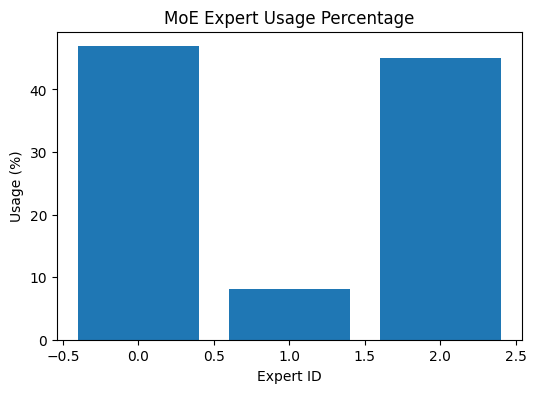

Expert Usage Counts: [192026.0, 33338.0, 184236.0]
Usage %: [46.88134765625, 8.13916015625, 44.9794921875]

2. Routing Visualization for Sample Text:


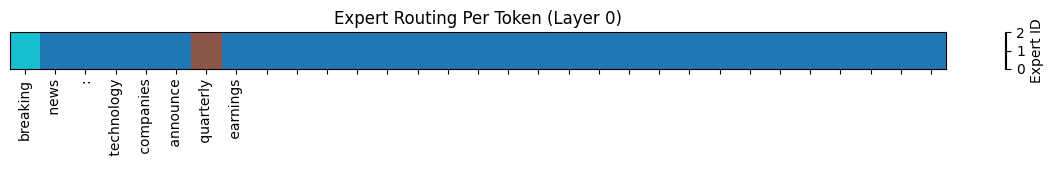


3. Token-Expert Pairs:
Token → Expert (Layer 0)
------------------------------
breaking             → expert 2
 news                → expert 0
:                    → expert 0
 technology          → expert 0
 companies           → expert 0
 announce            → expert 0
 quarterly           → expert 1
 earnings            → expert 0
                     → expert 0
                     → expert 0
                     → expert 0
                     → expert 0
                     → expert 0
                     → expert 0
                     → expert 0
                     → expert 0
                     → expert 0
                     → expert 0
                     → expert 0
                     → expert 0
                     → expert 0
                     → expert 0
                     → expert 0
                     → expert 0
                     → expert 0
                     → expert 0
                     → expert 0
                     → expert 0
                     → e

In [ ]:
import torch
import matplotlib.pyplot as plt

def plot_expert_usage(all_routes, num_experts):
    """
    all_routes: list of [n_layer, B, T] tensors collected over training
    num_experts: number of experts in the MoE layer
    """
    # Flatten all routing tensors across layers, batches, and time
    routes = torch.cat([r.reshape(-1) for r in all_routes])

    counts = torch.bincount(routes, minlength=num_experts).float()
    percentages = 100 * counts / counts.sum()

    plt.figure(figsize=(6,4))
    plt.bar(range(num_experts), percentages)
    plt.xlabel("Expert ID")
    plt.ylabel("Usage (%)")
    plt.title("MoE Expert Usage Percentage")
    plt.show()

    print("Expert Usage Counts:", counts.tolist())
    print("Usage %:", percentages.tolist())


def visualize_routing_on_text(model, text, block_size, layer_idx=0):
    """
    Visualize which expert handles each token for a given text.
    layer_idx: which transformer layer's routing to visualize (0 or 1 in your case)
    """
    model.eval()

    ids = encode(text, max_len=block_size)
    inp = torch.tensor(ids[:-1], device=device).unsqueeze(0)  # shape [1, T]

    with torch.no_grad():
        _, _, expert_choices = model(inp)  # expert_choices: [n_layer, B, T]

    # Get routing for specified layer
    routes = expert_choices[layer_idx, 0]  # [T]

    plt.figure(figsize=(12, 1.8))
    plt.imshow(routes.cpu().unsqueeze(0), cmap="tab10", aspect="auto", vmin=0, vmax=num_experts-1)
    plt.yticks([])
    plt.colorbar(label="Expert ID", ticks=range(num_experts))

    # Decode tokens for x-axis labels
    tokens = [decode([i]) for i in ids[:-1]]
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.title(f"Expert Routing Per Token (Layer {layer_idx})")
    plt.tight_layout()
    plt.show()


def print_token_expert_pairs(model, text, block_size, layer_idx=0):
    """
    Print which expert handles each token.
    """
    model.eval()

    ids = encode(text, max_len=block_size)
    inp = torch.tensor(ids[:-1], device=device).unsqueeze(0)

    with torch.no_grad():
        _, _, expert_choices = model(inp)

    tokens = [decode([i]) for i in ids[:-1]]
    experts = expert_choices[layer_idx, 0].cpu().tolist()

    print(f"Token → Expert (Layer {layer_idx})\n" + "-"*30)
    for tok, exp in zip(tokens, experts):
        print(f"{tok:20s} → expert {exp}")


# Collect routing data from test set
@torch.no_grad()
def collect_expert_routes(model, dataloader, max_batches=50):
    """
    Collect expert routing choices from the test set.
    """
    model.eval()
    all_routes = []

    for i, (input_ids, target_ids) in enumerate(dataloader):
        if i >= max_batches:
            break

        input_ids = input_ids.to(device)
        _, _, expert_choices = model(input_ids)
        all_routes.append(expert_choices.cpu())  # [n_layer, B, T]

    return all_routes


# Example usage:
print("Collecting expert routing data...")
all_routes = collect_expert_routes(model, test_loader, max_batches=50)

print("\n1. Overall Expert Usage Statistics:")
plot_expert_usage(all_routes, num_experts)

print("\n2. Routing Visualization for Sample Text:")
sample_text = "breaking news: technology companies announce quarterly earnings"
visualize_routing_on_text(model, sample_text, BLOCK_SIZE, layer_idx=0)

print("\n3. Token-Expert Pairs:")
print_token_expert_pairs(model, sample_text, BLOCK_SIZE, layer_idx=0)